# Let's try to get the newest CNN working for regressions too

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the 2nd and 3rd GPU
  try:
    gpu_list = [gpus[0],gpus[1]]
    tf.config.experimental.set_visible_devices(gpu_list, 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

print(logical_gpus)

gpu_list = ["/gpu:0", "/gpu:1"]
print(gpu_list)
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 2 Logical GPU
[LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:0', device_type='GPU'), LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:1', device_type='GPU')]
['/gpu:0', '/gpu:1']
Number of devices: 2


In [5]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'regression/Plots/'
modelpath = path_prefix+'regression/Models/'

In [6]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [7]:
inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["piplus","pi0"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

In [8]:
npp = len(pdata['piplus'])
print("Number of pi+ events: {}".format(npp))


Number of pi+ events: 435967


In [9]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [10]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras
from keras.wrappers.scikit_learn import KerasRegressor

In [11]:
training_classes = ['piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pp, pp_cells, pp_label = mu.createTrainingDatasets(training_classes, pdata, pcells)
training_classes = ['pi0']
p0, p0_cells, p0_label = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [12]:
ppcells_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pp_cells, (16, 16)))
ppcells_EMB1_flat = pp_cells['EMB1'].reshape(len(pp_cells['EMB1']), 128 * 4)


In [13]:
s_EMB2G_channels, scaler_EMB2G_channels = mu.standardCellsGeneral(ppcells_EMB2G_channels)
s_EMB1_flat, scaler_EMB1_flat = mu.standardCellsGeneral(ppcells_EMB1_flat)

In [14]:
p0cells_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(p0_cells, (16, 16)))
p0cells_EMB1_flat = p0_cells['EMB1'].reshape(len(p0_cells['EMB1']), 128 * 4)


In [15]:
s_0_EMB2G_channels, scaler_0_EMB2G_channels = mu.standardCellsGeneral(p0cells_EMB2G_channels)
s_0_EMB1_flat, scaler_0_EMB1_flat = mu.standardCellsGeneral(p0cells_EMB1_flat)

### All data loaded now. Time to add variuos calibration related information to frames.

In [16]:
pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT
p0['clusterEoverCalib'] = p0.clusterE / p0.cluster_ENG_CALIB_TOT
p0['clusterEoverTruth'] = p0.clusterE / p0.truthE
p0['cluster_ENG_ALL'] = p0.cluster_ENG_CALIB_TOT + p0.cluster_ENG_CALIB_OUT_T + p0.cluster_ENG_CALIB_DEAD_TOT

In [17]:
# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

p0['logE'] = np.log(p0.clusterE)
p0['logECalib'] = np.log(p0.cluster_ENG_CALIB_TOT)
p0['logECalibAll'] = np.log(p0.cluster_ENG_ALL)

In [18]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))

scaler_0_e = StandardScaler()
scaler_0_cal = StandardScaler()
scaler_0_calAll = StandardScaler()
# fit and transform in one step
p0['s_logE'] = scaler_0_e.fit_transform(p0['logE'].to_numpy().reshape(-1,1))
p0['s_logECalib'] = scaler_0_cal.fit_transform(p0['logECalib'].to_numpy().reshape(-1,1))
p0['s_logECalibAll'] = scaler_0_calAll.fit_transform(p0['logECalibAll'].to_numpy().reshape(-1,1))
scaler_0_eta = StandardScaler()
p0['s_eta'] = scaler_0_eta.fit_transform(p0.clusterEta.to_numpy().reshape(-1,1))

In [19]:
pp_features = np.column_stack((pp['s_logE'],pp['s_eta']))
p0_features = np.column_stack((p0['s_logE'],p0['s_eta']))

In [39]:
def channels_EMB2G_EMB1F_model_all2():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        opt = Adam(lr=1e-5, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [21]:
regressor_CNN = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all2, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all2().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)              

In [22]:
history_cnn = regressor_CNN.fit([ pp_features[pp.train], ppcells_EMB2G_channels[pp.train], ppcells_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], ppcells_EMB2G_channels[pp.val], ppcells_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))


.0160 - mae: 0.0738 - mse: 0.0160 - val_loss: 0.0158 - val_mae: 0.0725 - val_mse: 0.0158
Epoch 99/250
305176/305176 - 9s - loss: 0.0160 - mae: 0.0738 - mse: 0.0160 - val_loss: 0.0158 - val_mae: 0.0730 - val_mse: 0.0158
Epoch 100/250
305176/305176 - 9s - loss: 0.0160 - mae: 0.0737 - mse: 0.0160 - val_loss: 0.0158 - val_mae: 0.0732 - val_mse: 0.0158
Epoch 101/250
305176/305176 - 9s - loss: 0.0160 - mae: 0.0737 - mse: 0.0160 - val_loss: 0.0157 - val_mae: 0.0730 - val_mse: 0.0157
Epoch 102/250
305176/305176 - 9s - loss: 0.0160 - mae: 0.0736 - mse: 0.0160 - val_loss: 0.0157 - val_mae: 0.0728 - val_mse: 0.0157
Epoch 103/250
305176/305176 - 9s - loss: 0.0160 - mae: 0.0737 - mse: 0.0160 - val_loss: 0.0156 - val_mae: 0.0719 - val_mse: 0.0156
Epoch 104/250
305176/305176 - 9s - loss: 0.0160 - mae: 0.0737 - mse: 0.0160 - val_loss: 0.0156 - val_mae: 0.0721 - val_mse: 0.0156
Epoch 105/250
305176/305176 - 9s - loss: 0.0159 - mae: 0.0736 - mse: 0.0159 - val_loss: 0.0157 - val_mae: 0.0726 - val_mse: 0.

In [38]:
del channels_EMB2G_EMB1F_model_all2
del regressor_0_CNN

In [36]:
regressor_0_CNN = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all2, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all2().summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 512)          0           dense_49[0][0]                   
____________________________________________________________________________________________

In [37]:
history_0_cnn = regressor_0_CNN.fit([ p0_features[p0.train], p0cells_EMB2G_channels[p0.train], p0cells_EMB1_flat[p0.train] ],
                                              p0[p0.train].s_logECalib.to_numpy(),
                                              validation_data = ([ p0_features[p0.val], p0cells_EMB2G_channels[p0.val], p0cells_EMB1_flat[p0.val] ], p0[p0.val].s_logECalib.to_numpy()))


Train on 184723 samples, validate on 26390 samples
Epoch 1/250
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
184723/184723 - 13s - loss: 0.9558 - mae: 0.8478 - mse: 0.9558 - val_loss: 0.8507 - val_mae: 0.7995 - val_mse: 0.8507
Epoch 2/250
184723/184723 - 6s - loss: 0.6402 - mae: 0.6771 - mse: 0.6402 - val_loss: 0.3975 - val_mae: 0.5068 - val_mse: 0.3975
Epoch 3/250
184723/184723 - 6s - loss: 0.3695 - mae: 0.4663 - mse: 0.3695 - val_loss: 0.3335 - val_mae: 0.4296 - val_mse: 0.3335
Epoch 4/250
184723/184723 - 6s - loss: 0.3445 - mae: 0.4410 - mse: 0.3445 - val_loss: 0.3249 - val_mae: 0.4225 - val_mse: 0.3249
Epoch 5/250
184723/184723 - 6s - loss: 0.3347 - mae: 0.4334 - mse: 0.3347 - val_loss: 0.3179 - val_mae: 0.4183 - val_mse: 0.3179

KeyboardInterrupt: 

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


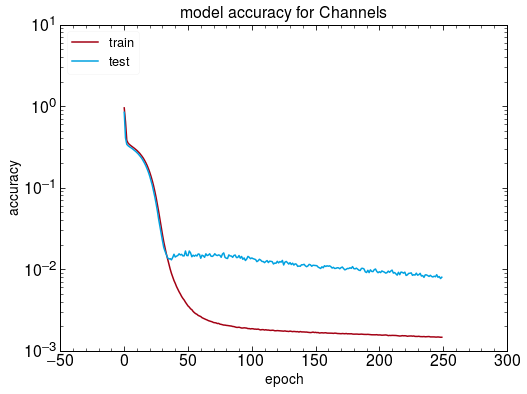

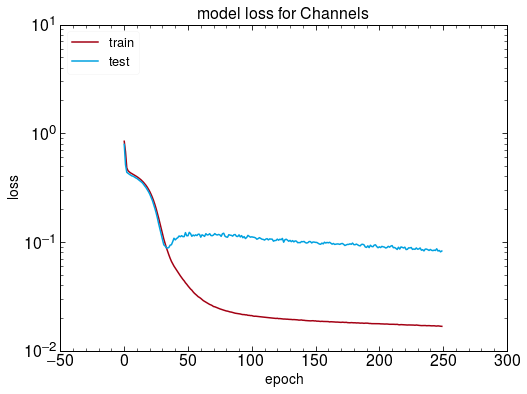

In [25]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_0_cnn.history['mse'])
    plt.plot(history_0_cnn.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_0_cnn.history['mae'])
    plt.plot(history_0_cnn.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

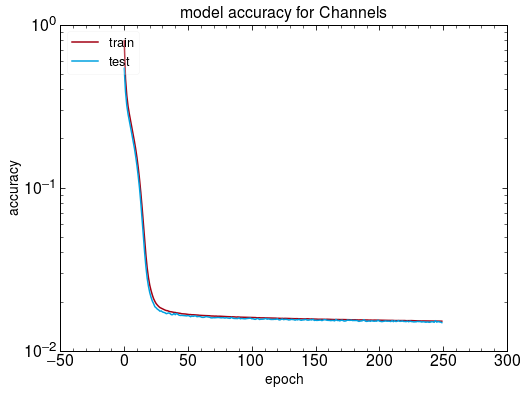

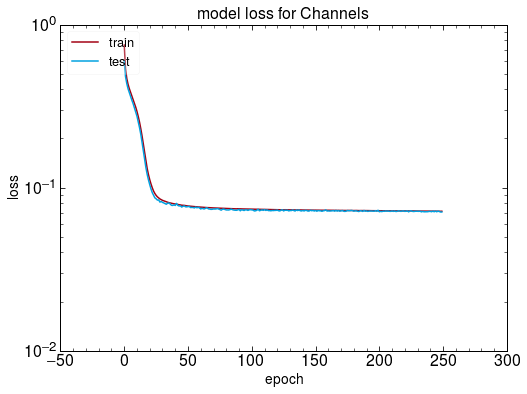

In [26]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn.history['mse'])
    plt.plot(history_cnn.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn.history['mae'])
    plt.plot(history_cnn.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [40]:
pp['predict_regressor_cnn'] = np.exp(scaler_cal.inverse_transform(regressor_CNN.predict([ pp_features, ppcells_EMB2G_channels, ppcells_EMB1_flat])))
pp['predict_regressor_cnn_EoverCalib'] = pp.predict_regressor_cnn / pp.cluster_ENG_CALIB_TOT

435967/1 - 4s


In [28]:
p0['predict_regressor_cnn'] = np.exp(scaler_0_cal.inverse_transform(regressor_0_CNN.predict([ p0_features, p0cells_EMB2G_channels, p0cells_EMB1_flat])))
p0['predict_regressor_cnn_EoverCalib'] = p0.predict_regressor_cnn / p0.cluster_ENG_CALIB_TOT

263891/1 - 3s


<Figure size 576x432 with 0 Axes>

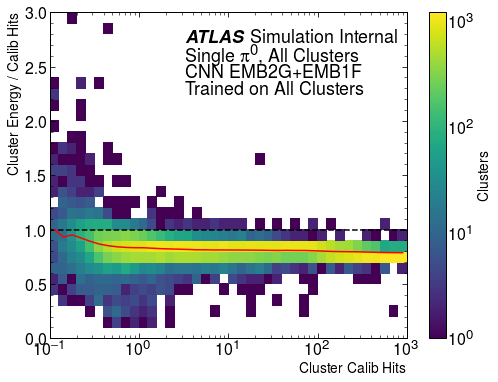

In [29]:
xcenter, medRegCNN_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].predict_regressor_cnn_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_0_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

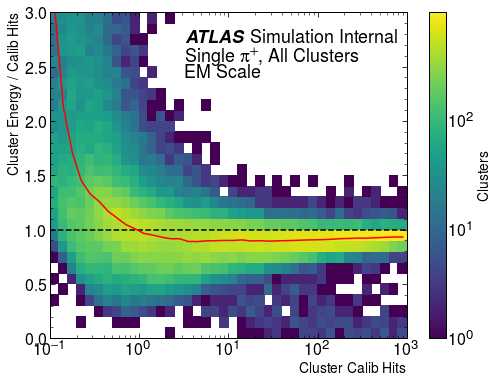

In [30]:
xcenter, medRegEM = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].clusterEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_em_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'EM Scale'}])

<Figure size 576x432 with 0 Axes>

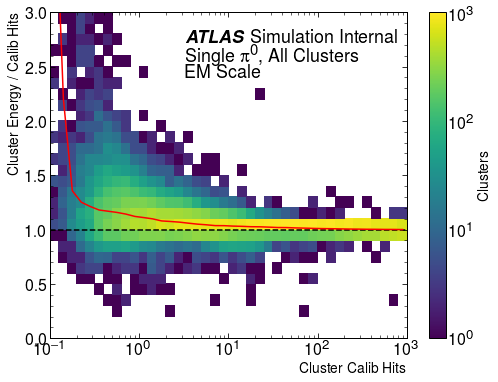

In [31]:
xcenter, medRegEM_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].clusterEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_em_0_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'EM Scale'}])

In [32]:
xcenter, medRegLC_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].clusterHadEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_had_0_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'LC Scale'}])

AttributeError: 'DataFrame' object has no attribute 'clusterHadEoverCalib'

In [ ]:
xcenter, medRegCNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

In [24]:
from tensorflow.keras.models import load_model


In [41]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [42]:
regressor_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=1)
print(baseline_nn_All_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_67 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_68 (Dense)             (None, 469)               440391    
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
regressor_0_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=2)
print(baseline_nn_All_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_23 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_24 (Dense)             (None, 469)               440391    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
regressor_All.model = tf.keras.models.load_model(modelpath + 'all.h5')

In [44]:
pp_file = ur.open(inputpath+'piplus.root')
pp_tree = pp_file['ClusterTree']
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten

combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

In [41]:
p0_file = ur.open(inputpath+'pi0.root')
p0_tree = p0_file['ClusterTree']
EMB1_0_cells = mu.setupCells(p0_tree, 'EMB1') # implicitly flatten
EMB2_0_cells = mu.setupCells(p0_tree, 'EMB2')
EMB3_0_cells = mu.setupCells(p0_tree, 'EMB3') # implicitly flatten

TileBar0_0_cells = mu.setupCells(p0_tree, 'TileBar0') # implicitly flatten
TileBar1_0_cells = mu.setupCells(p0_tree, 'TileBar1') # implicitly flatten
TileBar2_0_cells = mu.setupCells(p0_tree, 'TileBar2') # implicitly flatten

combine_All_0_cells = np.concatenate((EMB1_0_cells, EMB2_0_cells, EMB3_0_cells, TileBar0_0_cells, TileBar1_0_cells, TileBar2_0_cells), axis=1)
s_All_0_cells, scaler_All_0_cells = mu.standardCells(combine_All_0_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_0_input = np.column_stack((p0['s_logE'],p0['s_eta'],s_All_0_cells))

In [42]:
history_baseline_0_all = regressor_0_All.fit(All_0_input[p0.train], p0[p0.train].s_logECalib.to_numpy())


Train on 184723 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
184723/184723 - 6s - loss: 0.0583 - mae: 0.1363 - mse: 0.0583
Epoch 2/100
184723/184723 - 4s - loss: 0.0119 - mae: 0.0674 - mse: 0.0119
Epoch 3/100
184723/184723 - 4s - loss: 0.0082 - mae: 0.0535 - mse: 0.0082
Epoch 4/100
184723/184723 - 4s - loss: 0.0051 - mae: 0.0462 - mse: 0.0051
Epoch 5/100
184723/184723 - 4s - loss: 0.0050 - mae: 0.0437 - mse: 0.0050
Epoch 6/100
184723/184723 - 4s - loss: 0.0055 - mae: 0.0447 - mse: 0.0055
Epoch 7/100
184723/184723 - 4s - loss: 0.0069 - mae: 0.0457 - mse: 0.0069
Epoch 8/100
184723/184723 - 4s - loss: 0.0037 - mae: 0.0357 - mse: 0.0037
Epoch 9/100
184723/184723 - 4s - loss: 0.0067 - mae: 0.0439 - mse: 0.0067
Epoch 10

In [43]:
p0['predict_regressor_All'] = np.exp(scaler_0_cal.inverse_transform(regressor_0_All.predict(All_0_input)))
p0['predict_regressor_All_EoverCalib'] = p0.predict_regressor_All / p0.cluster_ENG_CALIB_TOT

263891/1 - 2s


<Figure size 576x432 with 0 Axes>

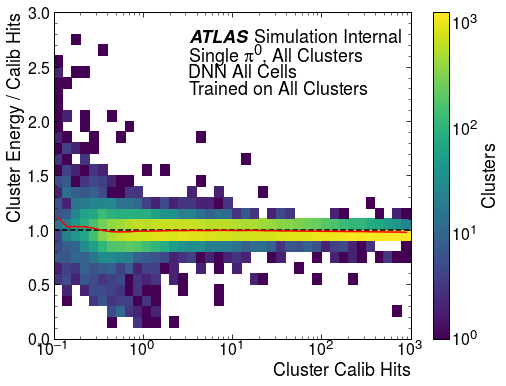

In [78]:
xcenter, medRegDNN_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].predict_regressor_All_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_DNN_0_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DNN All Cells'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

In [45]:
pp['predict_regressor_All'] = np.exp(scaler_cal.inverse_transform(regressor_All.predict(All_input)))
pp['predict_regressor_All_EoverCalib'] = pp.predict_regressor_All / pp.cluster_ENG_CALIB_TOT

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 576x432 with 0 Axes>

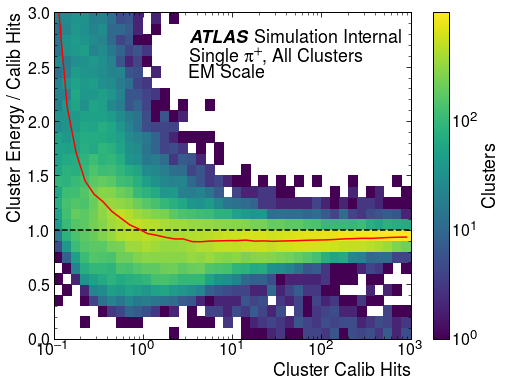

In [60]:
xcenter, medReg = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].clusterEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_EM_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'EM Scale'}])

<Figure size 576x432 with 0 Axes>

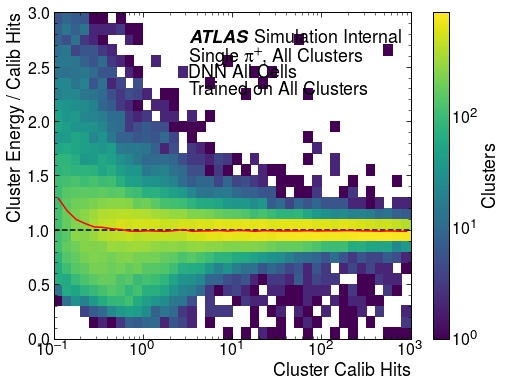

In [59]:
xcenter, medRegDNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_All_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_DNN_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DNN All Cells'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

In [46]:
pp['clusterHadE'] = pp.clusterE * pp.cluster_HAD_WEIGHT
pp['clusterHadEoverCalib'] = pp.clusterHadE / pp.cluster_ENG_CALIB_TOT
p0['clusterHadE'] = p0.clusterE * p0.cluster_HAD_WEIGHT
p0['clusterHadEoverCalib'] = p0.clusterHadE / p0.cluster_ENG_CALIB_TOT

<Figure size 576x432 with 0 Axes>

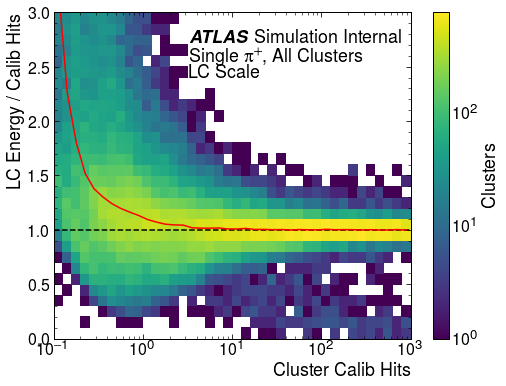

In [61]:
xcenter, medBaseLC = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].clusterHadEoverCalib,
                        plotpath+'hist_2D_calib_vs_lc_pp_profile.pdf','median',
                        xlabel = 'Cluster Calib Hits', ylabel = 'LC Energy / Calib Hits',
                        atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'LC Scale'}])

<Figure size 576x432 with 0 Axes>

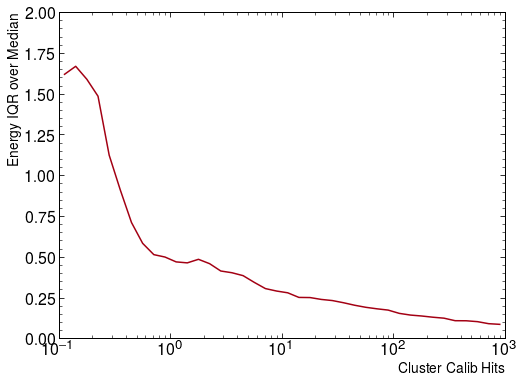

In [47]:
xcenter, iqrOverMedEM = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].clusterEoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

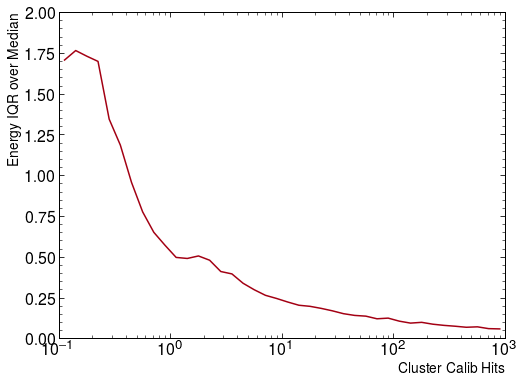

In [48]:
xcenter, iqrOverMedLC = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].clusterHadEoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

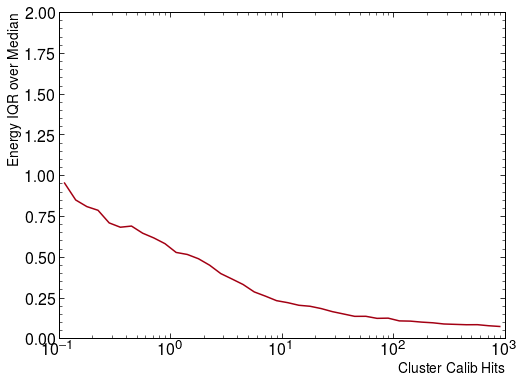

In [49]:
xcenter, iqrOverMedCNN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_cnn_EoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

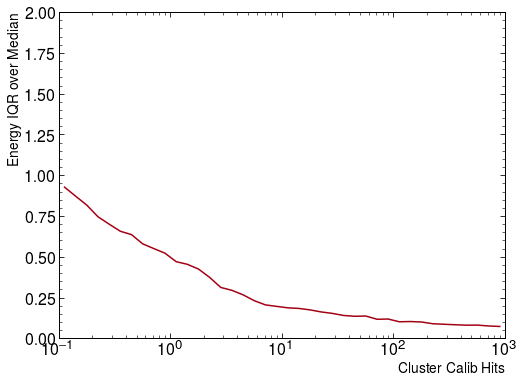

In [50]:
xcenter, iqrOverMedDNN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

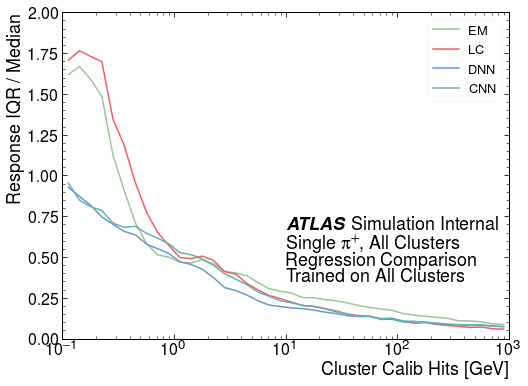

In [54]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedEM, iqrOverMedLC, iqrOverMedDNN, iqrOverMedCNN],
                labels = ['EM', 'LC', 'DNN', 'CNN'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_EM_LC_DNN_CNN.pdf",
                y_max = 2.,
                linestyles = ['solid', 'solid','solid', 'solid'],
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'},
                            {'x': 0.5, 'y': 0.175, 'text': 'Trained on All Clusters'}])

## Let's see about scaling?

In [37]:
def channels_EMB2G_EMB1F_model_all2_S():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim),name='input2')
        x2 = Dense(emb1_dim, activation='relu', kernel_initializer='normal')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        opt = Adam(lr=1e-5, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [38]:
regressor_CNN_s = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all2_S, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all2_S().summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 512)          0           dense_31[0][0]                   
____________________________________________________________________________________________

In [39]:
history_cnn_s = regressor_CNN_s.fit([ pp_features[pp.train], s_EMB2G_channels[pp.train], s_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], s_EMB2G_channels[pp.val], s_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))


.0162 - mae: 0.0746 - mse: 0.0162 - val_loss: 0.0164 - val_mae: 0.0810 - val_mse: 0.0164
Epoch 99/250
305176/305176 - 9s - loss: 0.0164 - mae: 0.0745 - mse: 0.0164 - val_loss: 0.0166 - val_mae: 0.0803 - val_mse: 0.0166
Epoch 100/250
305176/305176 - 9s - loss: 0.0163 - mae: 0.0744 - mse: 0.0163 - val_loss: 0.0162 - val_mae: 0.0791 - val_mse: 0.0162
Epoch 101/250
305176/305176 - 9s - loss: 0.0162 - mae: 0.0743 - mse: 0.0162 - val_loss: 0.0163 - val_mae: 0.0802 - val_mse: 0.0163
Epoch 102/250
305176/305176 - 9s - loss: 0.0161 - mae: 0.0744 - mse: 0.0161 - val_loss: 0.0165 - val_mae: 0.0804 - val_mse: 0.0165
Epoch 103/250
305176/305176 - 9s - loss: 0.0161 - mae: 0.0743 - mse: 0.0161 - val_loss: 0.0165 - val_mae: 0.0815 - val_mse: 0.0165
Epoch 104/250
305176/305176 - 9s - loss: 0.0161 - mae: 0.0742 - mse: 0.0161 - val_loss: 0.0170 - val_mae: 0.0834 - val_mse: 0.0170
Epoch 105/250
305176/305176 - 9s - loss: 0.0164 - mae: 0.0742 - mse: 0.0164 - val_loss: 0.0167 - val_mae: 0.0826 - val_mse: 0.

<Figure size 576x432 with 0 Axes>

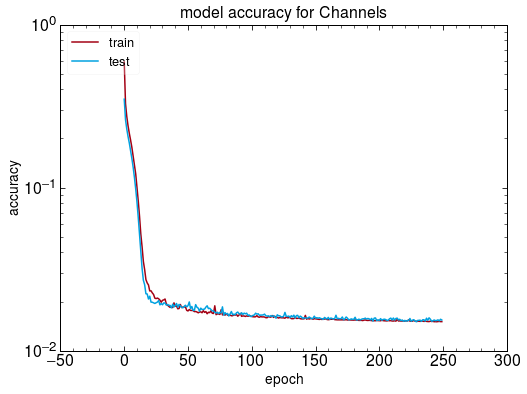

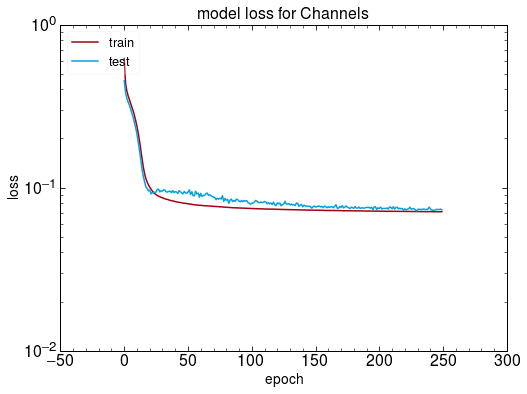

In [40]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_s.history['mse'])
    plt.plot(history_cnn_s.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_s.history['mae'])
    plt.plot(history_cnn_s.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [41]:
pp['predict_regressor_cnn_s'] = np.exp(scaler_cal.inverse_transform(regressor_CNN_s.predict([ pp_features, s_EMB2G_channels, s_EMB1_flat])))
pp['predict_regressor_cnn_s_EoverCalib'] = pp.predict_regressor_cnn_s / pp.cluster_ENG_CALIB_TOT

435967/1 - 4s


<Figure size 576x432 with 0 Axes>

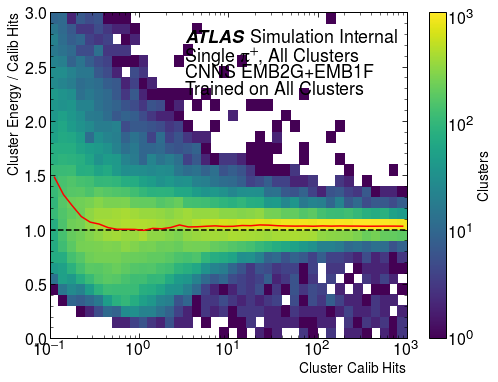

In [42]:
xcenter, medRegCNN_s = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_s_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_s_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNNS EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

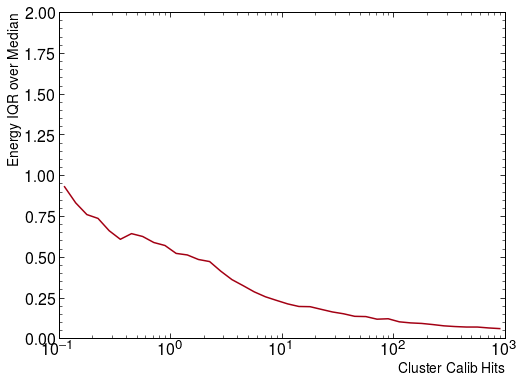

In [43]:
xcenter, iqrOverMedCNN_s = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_cnn_s_EoverCalib, statistic='iqrOverMed')

## Ok, the standardization doesn't really help much. Curious!

In [96]:
def channels_EMB2G_EMB1F_model_all4_S():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim),name='input2')
        x2 = Dense(emb1_dim, activation='relu', kernel_initializer='normal')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        # opt = Adam(lr=1e-5, decay=1e-6)
        opt = Adam(lr=2e-6) # try to prevent overfitting....
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [103]:
regressor_CNN_4S = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all4_S, batch_size=200*ngpu, epochs=450, verbose=2)
print(channels_EMB2G_EMB1F_model_all4_S().summary())

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dense_299 (Dense)               (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 13, 13)   3104        input1[0][0]                     
___________________________________________________________________________________________

In [104]:
history_cnn_4s = regressor_CNN_4S.fit([ pp_features[pp.train], s_EMB2G_channels[pp.train], s_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], s_EMB2G_channels[pp.val], s_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))


.2082 - mse: 0.0799 - val_loss: 0.0656 - val_mae: 0.1926 - val_mse: 0.0656
Epoch 78/450
305176/305176 - 9s - loss: 0.0734 - mae: 0.2042 - mse: 0.0734 - val_loss: 0.0629 - val_mae: 0.1886 - val_mse: 0.0629
Epoch 79/450
305176/305176 - 9s - loss: 0.0761 - mae: 0.2004 - mse: 0.0761 - val_loss: 0.0603 - val_mae: 0.1843 - val_mse: 0.0603
Epoch 80/450
305176/305176 - 9s - loss: 0.0690 - mae: 0.1962 - mse: 0.0690 - val_loss: 0.0579 - val_mae: 0.1809 - val_mse: 0.0579
Epoch 81/450
305176/305176 - 9s - loss: 0.0676 - mae: 0.1924 - mse: 0.0676 - val_loss: 0.0556 - val_mae: 0.1774 - val_mse: 0.0556
Epoch 82/450
305176/305176 - 9s - loss: 0.0663 - mae: 0.1882 - mse: 0.0663 - val_loss: 0.0533 - val_mae: 0.1733 - val_mse: 0.0533
Epoch 83/450
305176/305176 - 9s - loss: 0.0602 - mae: 0.1843 - mse: 0.0602 - val_loss: 0.0513 - val_mae: 0.1705 - val_mse: 0.0513
Epoch 84/450
305176/305176 - 9s - loss: 0.0600 - mae: 0.1806 - mse: 0.0600 - val_loss: 0.0491 - val_mae: 0.1666 - val_mse: 0.0491
Epoch 85/450
30

KeyboardInterrupt: 

In [ ]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_4s.history['mse'])
    plt.plot(history_cnn_4s.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_4s.history['mae'])
    plt.plot(history_cnn_4s.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [ ]:
pp['predict_regressor_cnn_4s'] = np.exp(scaler_cal.inverse_transform(regressor_CNN_4S.predict([ pp_features, s_EMB2G_channels, s_EMB1_flat])))
pp['predict_regressor_cnn_4s_EoverCalib'] = pp.predict_regressor_cnn_4s / pp.cluster_ENG_CALIB_TOT

In [ ]:
xcenter, medRegCNN_4S = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_4s_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_4s_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN4S EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

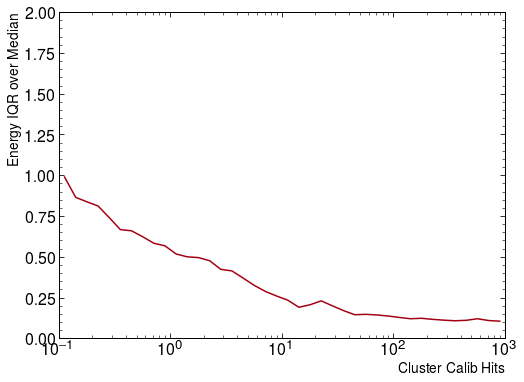

In [102]:
xcenter, iqrOverMedCNN_4S = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_cnn_4s_EoverCalib, statistic='iqrOverMed')

In [51]:
def channels_EMB2G_EMB1F_model_all5_S():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(64, (4, 4), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(128, (2, 2), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1)
        x1_2 = Flatten()(x1)
        x1_2 = Dense(128, activation='relu')(x1)
        x1_2 = Dropout(0.2)(x1)
        x1_2 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim),name='input2')
        x2 = Dense(emb1_dim, activation='relu', kernel_initializer='normal')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x1_2, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        opt = Adam(lr=1e-5, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [52]:
regressor_CNN_5S = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all5_S, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all5_S().summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 13, 13)   6208        input1[0][0]                     
____________________________________________________________________________________________

In [53]:
history_cnn_5s = regressor_CNN_5S.fit([ pp_features[pp.train], s_EMB2G_channels[pp.train], s_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], s_EMB2G_channels[pp.val], s_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))


Train on 305176 samples, validate on 43598 samples
Epoch 1/250
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
305176/305176 - 17s - loss: 0.4791 - mae: 0.5270 - mse: 0.4791 - val_loss: 0.2755 - val_mae: 0.3995 - val_mse: 0.2755
Epoch 2/250
305176/305176 - 10s - loss: 0.2775 - mae: 0.3958 - mse: 0.2775 - val_loss: 0.2268 - val_mae: 0.3546 - val_mse: 0.2268
Epoch 3/250
305176/305176 - 10s - loss: 0.2389 - mae: 0.3617 - mse: 0.2389 - val_loss: 0.2014 - val_mae: 0.3318 - val_mse: 0.2014
Epoch 4/250
305176/305176 - 10s - loss: 0.2104 - mae: 0.3409 - mse: 0.2104 - val_loss: 0.1844 - val_mae: 0.3181 - val_mse: 0.1844
Epoch 5/250
305176/305176 - 10s - loss: 0.1906 - mae: 0.3241 - mse: 0.1906 - val_loss: 0.1678 - val_mae: 0.3003 - val_mse: 0.

KeyboardInterrupt: 

<Figure size 576x432 with 0 Axes>

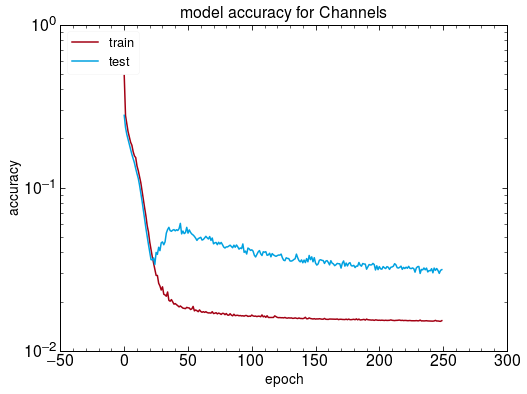

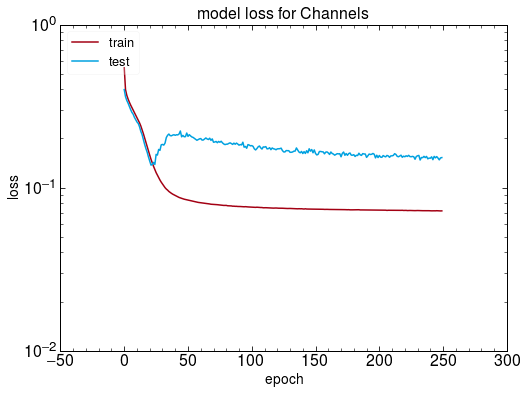

In [28]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_5s.history['mse'])
    plt.plot(history_cnn_5s.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_5s.history['mae'])
    plt.plot(history_cnn_5s.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [41]:
pp['predict_regressor_cnn_5s'] = np.exp(scaler_cal.inverse_transform(regressor_CNN_5S.predict([ pp_features, s_EMB2G_channels, s_EMB1_flat])))
pp['predict_regressor_cnn_5s_EoverCalib'] = pp.predict_regressor_cnn_5s / pp.cluster_ENG_CALIB_TOT

435967/1 - 6s


<Figure size 576x432 with 0 Axes>

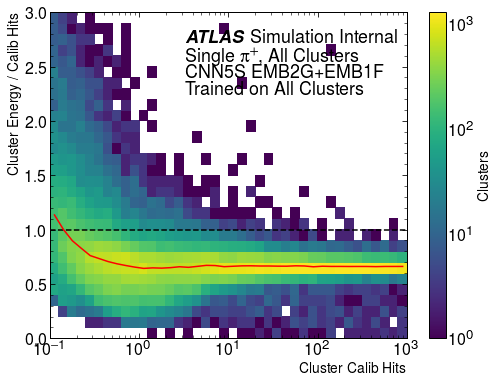

In [45]:
xcenter, medRegCNN_5S = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_5s_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_5s_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN5S EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

Weird biases, like in the last one. Even worse!

<Figure size 576x432 with 0 Axes>

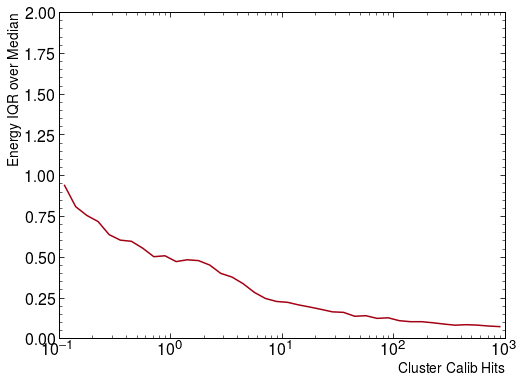

In [43]:
xcenter, iqrOverMedCNN_5S = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_cnn_5s_EoverCalib, statistic='iqrOverMed')

In [34]:
def channels_EMB2G_EMB1F_model_all6_S():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(64, (2, 2), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1)
        x1_2 = Flatten()(x1)
        x1_2 = Dense(128, activation='relu')(x1)
        x1_2 = Dropout(0.2)(x1)
        x1_2 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim),name='input2')
        x2 = Dense(emb1_dim, activation='relu', kernel_initializer='normal')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x1_2, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        opt = Adam(lr=1e-5, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [35]:
regressor_CNN_6S = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all6_S, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all6_S().summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 13, 13)   3104        input1[0][0]                     
____________________________________________________________________________________________

In [37]:
history_cnn_6s = regressor_CNN_6S.fit([ pp_features[pp.train], s_EMB2G_channels[pp.train], s_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], s_EMB2G_channels[pp.val], s_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))


224 - val_mae: 0.1097 - val_mse: 0.0224
Epoch 99/250
305176/305176 - 10s - loss: 0.0164 - mae: 0.0752 - mse: 0.0164 - val_loss: 0.0210 - val_mae: 0.1053 - val_mse: 0.0210
Epoch 100/250
305176/305176 - 10s - loss: 0.0163 - mae: 0.0751 - mse: 0.0163 - val_loss: 0.0217 - val_mae: 0.1082 - val_mse: 0.0217
Epoch 101/250
305176/305176 - 9s - loss: 0.0165 - mae: 0.0751 - mse: 0.0165 - val_loss: 0.0220 - val_mae: 0.1071 - val_mse: 0.0220
Epoch 102/250
305176/305176 - 9s - loss: 0.0167 - mae: 0.0751 - mse: 0.0167 - val_loss: 0.0229 - val_mae: 0.1098 - val_mse: 0.0229
Epoch 103/250
305176/305176 - 9s - loss: 0.0163 - mae: 0.0750 - mse: 0.0163 - val_loss: 0.0199 - val_mae: 0.0991 - val_mse: 0.0199
Epoch 104/250
305176/305176 - 9s - loss: 0.0162 - mae: 0.0749 - mse: 0.0162 - val_loss: 0.0215 - val_mae: 0.1075 - val_mse: 0.0215
Epoch 105/250
305176/305176 - 9s - loss: 0.0162 - mae: 0.0748 - mse: 0.0162 - val_loss: 0.0197 - val_mae: 0.0998 - val_mse: 0.0197
Epoch 106/250
305176/305176 - 9s - loss: 0

<Figure size 576x432 with 0 Axes>

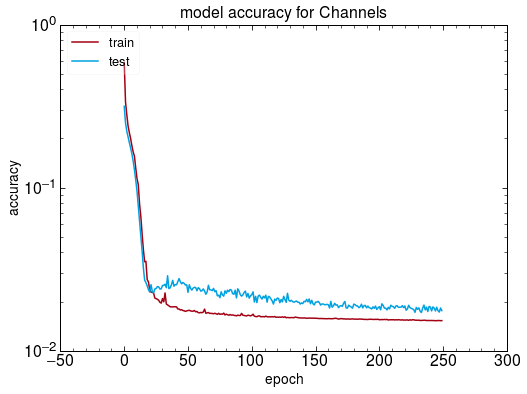

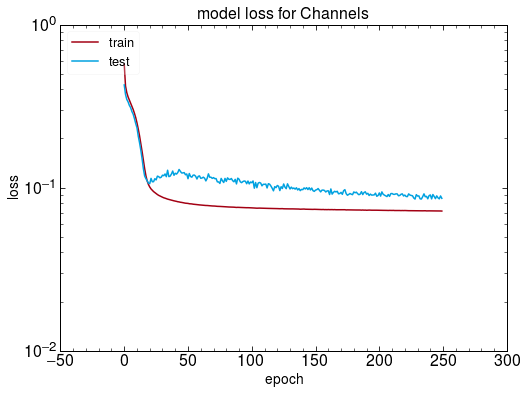

In [38]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_6s.history['mse'])
    plt.plot(history_cnn_6s.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_6s.history['mae'])
    plt.plot(history_cnn_6s.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [39]:
pp['predict_regressor_cnn_6s'] = np.exp(scaler_cal.inverse_transform(regressor_CNN_6S.predict([ pp_features, s_EMB2G_channels, s_EMB1_flat])))
pp['predict_regressor_cnn_6s_EoverCalib'] = pp.predict_regressor_cnn_6s / pp.cluster_ENG_CALIB_TOT

435967/1 - 5s


<Figure size 576x432 with 0 Axes>

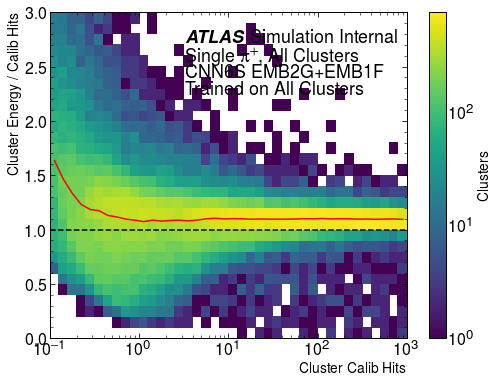

In [40]:
xcenter, medRegCNN_6S = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_6s_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_6s_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN6S EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

In [61]:
def channels_EMB2G_EMB1F_model_all7_S():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first',kernel_initializer='normal')(input1) # change to smaller filter size
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim),name='input2')
        x2 = Dense(emb1_dim, activation='relu', kernel_initializer='normal')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        opt = Adam(lr=1e-5, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [62]:
regressor_CNN_7S = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all7_S, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all7_S().summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_123 (Dense)               (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dropout_45 (Dropout)            (None, 512)          0           dense_123[0][0]                  
___________________________________________________________________________________________

In [63]:
history_cnn_7s = regressor_CNN_7S.fit([ pp_features[pp.train], s_EMB2G_channels[pp.train], s_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], s_EMB2G_channels[pp.val], s_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))


.0168 - mae: 0.0757 - mse: 0.0168 - val_loss: 0.0198 - val_mae: 0.0975 - val_mse: 0.0198
Epoch 99/250
305176/305176 - 9s - loss: 0.0166 - mae: 0.0758 - mse: 0.0166 - val_loss: 0.0179 - val_mae: 0.0902 - val_mse: 0.0179
Epoch 100/250
305176/305176 - 9s - loss: 0.0165 - mae: 0.0756 - mse: 0.0165 - val_loss: 0.0187 - val_mae: 0.0918 - val_mse: 0.0187
Epoch 101/250
305176/305176 - 9s - loss: 0.0166 - mae: 0.0756 - mse: 0.0166 - val_loss: 0.0185 - val_mae: 0.0916 - val_mse: 0.0185
Epoch 102/250
305176/305176 - 9s - loss: 0.0165 - mae: 0.0756 - mse: 0.0165 - val_loss: 0.0186 - val_mae: 0.0917 - val_mse: 0.0186
Epoch 103/250
305176/305176 - 9s - loss: 0.0164 - mae: 0.0755 - mse: 0.0164 - val_loss: 0.0184 - val_mae: 0.0923 - val_mse: 0.0184
Epoch 104/250
305176/305176 - 9s - loss: 0.0165 - mae: 0.0755 - mse: 0.0165 - val_loss: 0.0181 - val_mae: 0.0913 - val_mse: 0.0181
Epoch 105/250
305176/305176 - 9s - loss: 0.0165 - mae: 0.0754 - mse: 0.0165 - val_loss: 0.0181 - val_mae: 0.0904 - val_mse: 0.

<Figure size 576x432 with 0 Axes>

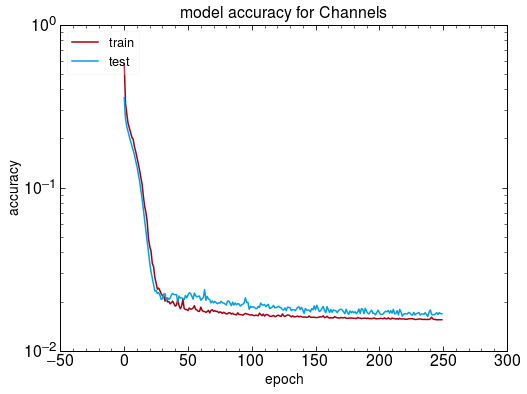

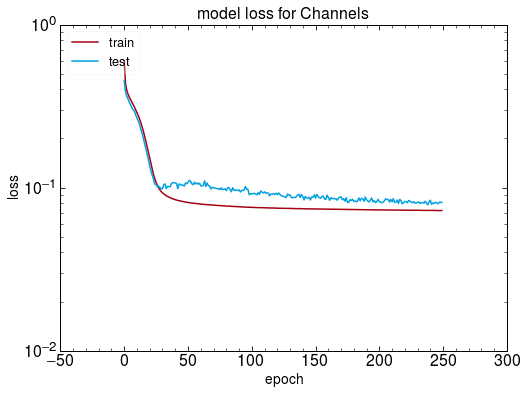

In [64]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_7s.history['mse'])
    plt.plot(history_cnn_7s.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_7s.history['mae'])
    plt.plot(history_cnn_7s.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [65]:
pp['predict_regressor_cnn_7s'] = np.exp(scaler_cal.inverse_transform(regressor_CNN_7S.predict([ pp_features, s_EMB2G_channels, s_EMB1_flat])))
pp['predict_regressor_cnn_7s_EoverCalib'] = pp.predict_regressor_cnn_6s / pp.cluster_ENG_CALIB_TOT

435967/1 - 4s


<Figure size 576x432 with 0 Axes>

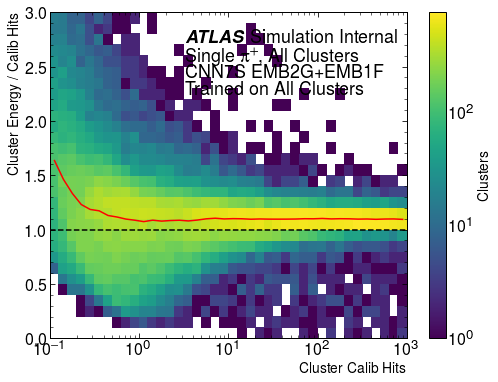

In [66]:
xcenter, medRegCNN_7S = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_7s_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_7s_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN7S EMB2G+EMB1F'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

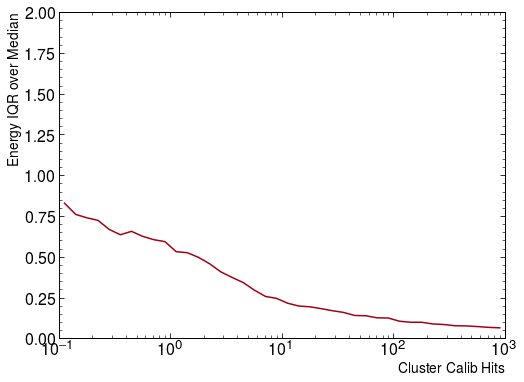

In [67]:
xcenter, iqrOverMedCNN_7S = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_cnn_7s_EoverCalib, statistic='iqrOverMed')

# Resolution plots

<Figure size 576x432 with 0 Axes>

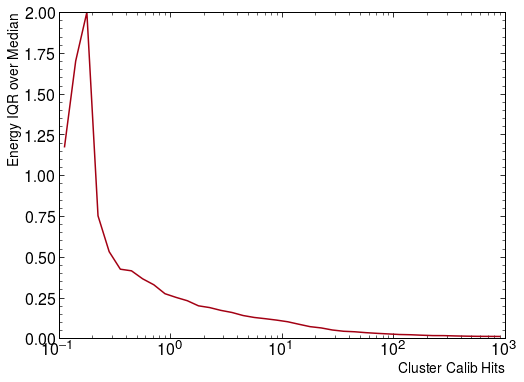

In [45]:
xcenter, iqrOverMed_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].clusterEoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

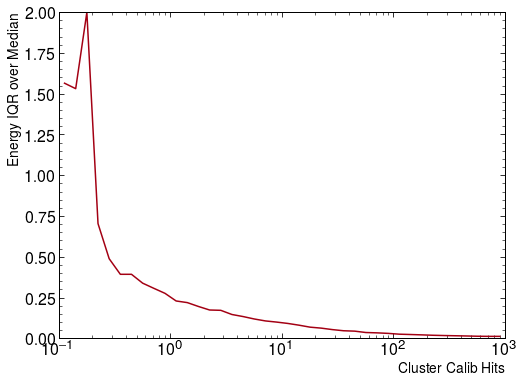

In [46]:
xcenter, iqrOverMedLC_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].clusterHadEoverCalib, statistic='iqrOverMed')

In [ ]:
predict_regressor_All_EoverCalib

<Figure size 576x432 with 0 Axes>

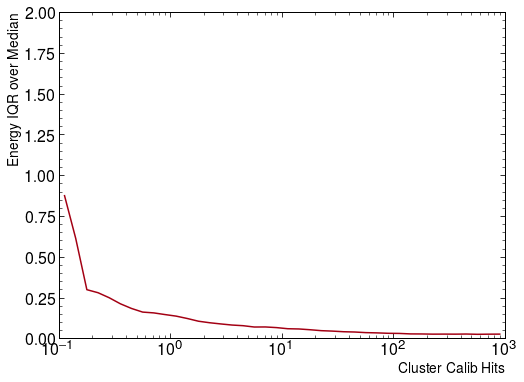

In [47]:
xcenter, iqrOverMedDNN_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

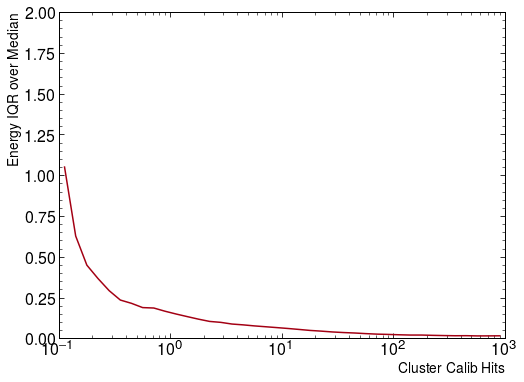

In [48]:
xcenter, iqrOverMedCNN_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].predict_regressor_cnn_EoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

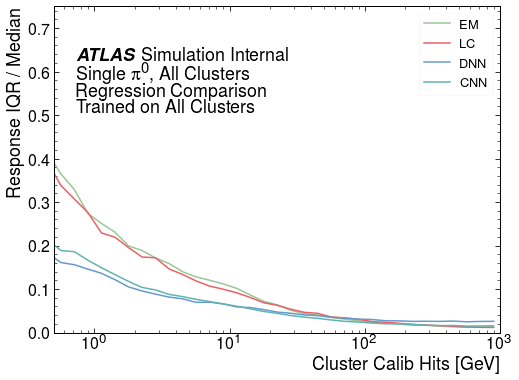

In [58]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMed_0, iqrOverMedLC_0, iqrOverMedDNN_0, iqrOverMedCNN_0],
                labels = ['EM', 'LC', 'DNN', 'CNN'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_EM_LC_DNN_CNN_0.pdf",
                x_min = 0.5, x_max = 1000., y_max = 0.75,
                linestyles = ['solid', 'solid','solid','solid'],
                atlas_x = 0.05, atlas_y = 0.875, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $\pi^{0}$, All Clusters'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'},
                            {'x': 0.05, 'y': 0.675, 'text': 'Trained on All Clusters'}])